# Content of the notebook

This notebook contains all steps to train and evaluate the final machine learning model that is presented in the paper "Prediction of Michaelis constants $K_M$ from structural features". The notebook consists of the following steps:

1. Loading train, test, and validation data (that was created with the notebook "Downloading and preprocessing BRENDA data")
2. Training the Graph Neural Network with substrates and two extra molecular features (MW, LogP) as inputs
3. Training a gradient boosting model with enzyme and substrate information as inputs
4. Training a gradient boosting model with only enzyme information (functional domains) as input
5. Plotting figure 4 of our paper

All datasets are stored in one directory. The location of this directory can be changed (to the corresponding path on your PC) in the python file "directory_infomation.py".

Loading all the necessary packages and functions to execute the code:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
from sklearn.metrics import r2_score
import xgboost as xgb
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

from directory_infomation import *
from functions_and_dicts_data_preprocessing_GNN import *
from build_GNN import *

## 1. Loading train, test, and validation data

Before we load and create the data to train and validate our machine learning models, we must calculate the feature vectors (for the atoms and bonds) for all Molfiles (if they do not already exist). If the MDL Molfiles have not yet been downloaded (e.g., by executing the notebook "Downloading and preprocessing BRENDA data"), download all files with the following cell (otherwise skip it):

In [2]:
#download_mol_files()

In [3]:
calculate_atom_and_bond_feature_vectors()

In [4]:
brenda_train = pd.read_pickle(datasets_dir + "training_data.pkl")
[train_XE, train_X, train_A, train_extras, train_FunD, train_y] = create_input_and_output_data(
    df = brenda_train)

brenda_test = pd.read_pickle(datasets_dir + "test_data.pkl")
[test_XE, test_X, test_A, test_extras, test_FunD, test_y] = create_input_and_output_data(
    df = brenda_test)

brenda_valid = pd.read_pickle(datasets_dir + "validation_data.pkl")
[valid_XE, valid_X, valid_A, valid_extras, valid_FunD, valid_y] = create_input_and_output_data(
    df = brenda_valid)

## 2. Training the Graph Neural Network with substrates and two extra molecular features (MW, LogP) as inputs

In [5]:
# Set regularization rates
l2_reg_conv = 0.05                
l2_reg_fc = 0.2

### (a) Training the Graph Neural Network:

Uncomment the following cell for newly training the model:

In [6]:
'''
model = DMPNN(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = 0.1,
                  D = 100, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0,ada_rho = 0.95)

model.optimizer.learning_rate.assign(1e-1)
model.fit([np.array(train_XE), np.array(train_X), np.array(train_A), np.array(train_extras)], np.array(train_y),
          epochs=40, batch_size=64, shuffle = True, verbose = 1,
         validation_data=([np.array(valid_XE), np.array(valid_X), np.array(valid_A), np.array(valid_extras)],
                           np.array(valid_y)))

pred_test = model.predict([np.array(test_XE), np.array(test_X), np.array(test_A), np.array(test_extras)])
print(r2_score(np.reshape(test_y, (-1,1)), pred_test))
print(np.mean(abs(pred_test - np.reshape(test_y, (-1,1)))**2))


model.optimizer.learning_rate.assign(1e-2)
model.fit([np.array(train_XE), np.array(train_X), np.array(train_A), np.array(train_extras)], np.array(train_y),
          epochs=10, batch_size=64, shuffle = True, verbose = 1,
         validation_data=([np.array(valid_XE), np.array(valid_X), np.array(valid_A), np.array(valid_extras)],
                           np.array(valid_y)))
''';

If the model shall not be trained again, the parameters of the already trained model can be loaded with the following cell. If model was newly trained, do not execute the following cell.

In [7]:
model = DMPNN(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = 0.1,
                  D = 100, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = 0.95)

model.load_weights(datasets_dir + "\model_weights\GCN_D100_MW_LogP")

### (b) Validating the model on test and validation set:

In [8]:
pred_test = model.predict([np.array(test_XE), np.array(test_X), np.array(test_A), np.array(test_extras)])
GNN_test_MSE = np.mean(abs(pred_test - np.reshape(test_y, (-1,1)))**2)
GNN_test_R2 = r2_score(np.reshape(test_y, (-1,1)), pred_test)
print("Performance on the test set:")
print("R² value: %s" % GNN_test_R2)
print("Mean squared error (MSE): %s" % GNN_test_MSE)

pred_valid = model.predict([np.array(valid_XE), np.array(valid_X), np.array(valid_A), np.array(valid_extras)])
GNN_valid_MSE = np.mean(abs(pred_valid - np.reshape(valid_y, (-1,1)))**2)
GNN_valid_R2 = r2_score(np.reshape(valid_y, (-1,1)), pred_valid)
print("\n Performance on the validation set:")
print("R² value: %s" % GNN_valid_R2)
print("Mean squared error (MSE): %s" % GNN_valid_MSE)

Performance on the test set:
R² value: 0.3555520051085065
Mean squared error (MSE): 0.796735318591988

 Performance on the validation set:
R² value: 0.418989774819409
Mean squared error (MSE): 0.7076457985639311


Save MSE and R² in numpy-file for comparison with FCNN with ECFP as input:

In [9]:
np.save(datasets_dir + "GNN_test_MSE.npy", GNN_test_MSE)
np.save(datasets_dir + "GNN_valid_MSE.npy", GNN_valid_MSE)

np.save(datasets_dir + "GNN_test_R2.npy", GNN_test_R2)
np.save(datasets_dir + "GNN_valid_R2.npy", GNN_valid_R2)

## 3. Training a gradient boosting model with enzyme and substrate information as inputs

### (a) Creating input for the gradient boosting model:

First, we extract the task specific fingerprint for the substrates from the model that was trained in step 2. for all data points in the training, validation, and test set:

Defining a function to extract fingerprints:

In [10]:
get_fingerprint_fct = K.function([model.layers[0].input,model.layers[28].input, model.layers[3].input,
                                     model.layers[38].input],
                                  [model.layers[-9].output])

def get_task_specific_fingerprints(XE, X, A, extras, get_fingerprint_fct):
    #We cannot process too many samples simultaneously. Therefore we split the data in bunches of max 300 samples:
    fingerprints = get_fingerprint_fct([np.array(XE[0:300]), np.array(X[0:300]),
                                               np.array(A[0:300]),
                           np.array(extras[0:300])])[0]
    for i in range(int(len(XE)/300)+1):
        fingerprints_new = get_fingerprint_fct([np.array(XE[(300*(i+1)):(300*(i+2))]),
                                                   np.array(X[(300*(i+1)):(300*(i+2))]),
                                                   np.array(A[(300*(i+1)):(300*(i+2))]),
                                                   np.array(extras[(300*(i+1)):(300*(i+2))])])[0]
        fingerprints = np.concatenate([fingerprints, fingerprints_new])
        
    return(fingerprints)

Calculating fingerprints for the substrates:

In [11]:
fingerprints_train = get_task_specific_fingerprints(XE = train_XE, X = train_X, A = train_A,
                                                    extras = train_extras, get_fingerprint_fct = get_fingerprint_fct)

fingerprints_test = get_task_specific_fingerprints(XE = test_XE, X = test_X, A = test_A,
                                                    extras = test_extras, get_fingerprint_fct = get_fingerprint_fct)

fingerprints_valid = get_task_specific_fingerprints(XE = valid_XE, X = valid_X, A = valid_A,
                                                    extras = valid_extras, get_fingerprint_fct = get_fingerprint_fct)

Since we don't need the input tensors for the GNN anymore, we remove it from the RAM:

In [12]:
train_XE, train_X, train_A, train_extras = 0,0,0,0
test_XE, test_X, test_A, test_extras = 0,0,0,0
valid_XE, valid_X, valid_A, valid_extras = 0,0,0,0

Creating the input for the gradient boosting model (task-specific fingerprint concatenated with vector with information about the functional domains of the enzyme):

In [13]:
train_X = np.concatenate([fingerprints_train, train_FunD], axis = 1)
test_X = np.concatenate([fingerprints_test, test_FunD], axis = 1)
valid_X = np.concatenate([fingerprints_valid, valid_FunD], axis = 1)

### (b) Training gradient boosting model to predict $K_M$:

Fitting model with substrate and enzyme information:

In [14]:
dtrain = xgb.DMatrix(train_X, label = train_y)
dtest = xgb.DMatrix(test_X, label = test_y)
dvalid = xgb.DMatrix(valid_X, label = valid_y)

Uncomment the following cell for newly training the model:

In [15]:
'''
param = { 'objective': 'reg:squarederror',"learning_rate" : 0.04, "max_depth" : 4, "subsample" : 0.9,
         "tree_method" : "gpu_hist", "sampling_method" : "gradient_based", "reg_lambda" : 0.8,
        "max_delta_step" : 10, "min_child_weight" : 3}
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

num_round = 1600
bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval= 0)

#Save model
pickle.dump(bst, open(datasets_dir + "model_weights\\xgboost_model.dat", "wb"))
''';

If the model shall not be trained again, the parameters of the already trained model can be loaded with the following cell. If model was newly trained, do not execute the following cell:

In [16]:
bst = pickle.load(open(datasets_dir + "model_weights\\xgboost_model.dat", "rb"))

### (c) Validating the model:

In [17]:
pred_test = bst.predict(dtest)
pred_test_full_model = pred_test
GB_enzyme_sub_test_MSE = np.mean(abs(pred_test - np.reshape(test_y, (-1)))**2)
GB_enzyme_sub_test_R2 = r2_score(np.reshape(test_y, (-1,1)), pred_test)
print("Performance on the test set:")
print("R² value: %s" % GB_enzyme_sub_test_R2)
print("Mean squared error (MSE): %s" % GB_enzyme_sub_test_MSE)

pred_valid = bst.predict(dvalid)
GB_enzyme_sub_valid_MSE = np.mean(abs(pred_valid - np.reshape(valid_y, (-1)))**2)
GB_enzyme_sub_valid_R2 = r2_score(np.reshape(valid_y, (-1,1)), pred_valid)
print("\n Performance on the validation set:")
print("R² value: %s" % GB_enzyme_sub_valid_R2)
print("Mean squared error (MSE): %s" % GB_enzyme_sub_valid_MSE)

Performance on the test set:
R² value: 0.4190326518043974
Mean squared error (MSE): 0.7182537752081934

 Performance on the validation set:
R² value: 0.48871712117746224
Mean squared error (MSE): 0.6227208496442254


## 4. Training a gradient boosting model with only enzyme information (functional domains) as input

### (a) Training the model:

In [18]:
train_FunD = np.array(train_X[:,102:])
test_FunD = np.array(test_X[:,102:])
valid_FunD = np.array(valid_X[:,102:])

dtrain = xgb.DMatrix(train_FunD, label = train_y)
dtest = xgb.DMatrix(test_FunD, label = test_y)
dvalid = xgb.DMatrix(valid_FunD, label = valid_y)

param = { 'objective': 'reg:squarederror',"learning_rate" : 0.04, "max_depth" : 4, "subsample" : 0.9,
         "tree_method" : "gpu_hist", "sampling_method" : "gradient_based", "reg_lambda" : 0.8,
        "max_delta_step" : 10, "min_child_weight" : 3}
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

num_round = 1200
bst_enzyme = xgb.train(param, dtrain, num_round, evallist, verbose_eval = 0)

###  (b) Validating the model:

In [19]:
pred_test = bst_enzyme.predict(dtest)
GB_enzyme_test_MSE = np.mean(abs(pred_test - np.reshape(test_y, (-1)))**2)
GB_enzyme_test_R2 = r2_score(np.reshape(test_y, (-1,1)), pred_test)
print("Performance on the test set:")
print("R² value: %s" % GB_enzyme_test_R2)
print("Mean squared error: %s" % GB_enzyme_test_MSE)

pred_valid = bst_enzyme.predict(dvalid)
GB_enzyme_valid_MSE = np.mean(abs(pred_valid - np.reshape(valid_y, (-1)))**2)
GB_enzyme_valid_R2 = r2_score(np.reshape(valid_y, (-1,1)), pred_valid)
print("\n Performance on the validation set:")
print("R² value: %s" % GB_enzyme_valid_R2)
print("Mean squared error: %s" % GB_enzyme_valid_MSE)

Performance on the test set:
R² value: 0.16780761764441854
Mean squared error: 1.0288449465926819

 Performance on the validation set:
R² value: 0.24296691992379704
Mean squared error: 0.922034166134212


## 5. Plotting figure 4 of the paper "Prediction of Michaelis constants $K_M$ from structural features"

#### Figure 4c:

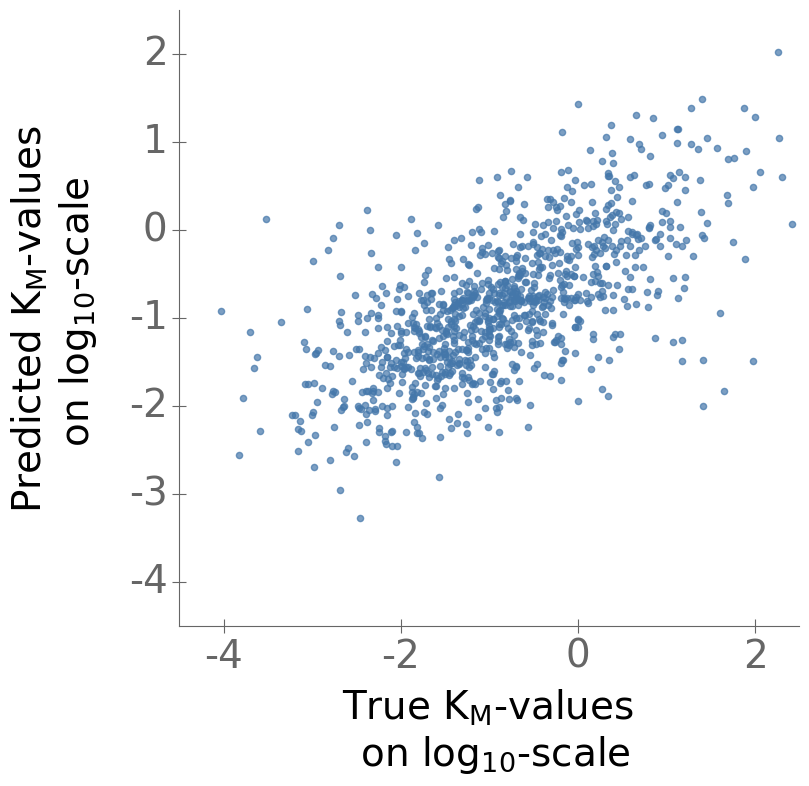

In [20]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})

test_pred = pred_test_full_model


plt.ylim(ymax = 2.5, ymin = -4.5)
plt.xlim(xmax = 2.5, xmin = -4.5)

ax.tick_params(axis='x', length=10)
ax.tick_params(axis='y', length=10)
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.xaxis.set_label_coords(0.5, -0.1)

plt.ylabel("Predicted $K_M$-values \n on $\log_{10}$-scale")
plt.xlabel("True $K_M$-values \n on $\log_{10}$-scale")
plt.scatter(test_y, test_pred, alpha = 0.7, s=20)
plt.show()

Prediction with the naive approach of taking the mean of the $ K_M$ values in the training set:

In [21]:
mean_pred = np.mean(train_y)

mean_pred_test_MSE = np.mean(abs(mean_pred - np.reshape(test_y, (-1)))**2)
mean_pred_test_R2 = np.round(r2_score(np.reshape(test_y, (-1)), [mean_pred]*len(test_y)),2)
print("Performance on the test set:")
print("R² value: %s" % mean_pred_test_R2)
print("Mean squared error: %s" % mean_pred_test_MSE)

mean_pred_valid_MSE = np.mean(abs(mean_pred - np.reshape(valid_y, (-1)))**2)
mean_pred_valid_R2 = np.round(r2_score(np.reshape(valid_y, (-1)), [mean_pred]*len(valid_y)),2)
print("\n Performance on the validation set:")
print("R² value: %s" % mean_pred_valid_R2)
print("Mean squared error: %s" % mean_pred_valid_MSE)

Performance on the test set:
R² value: -0.0
Mean squared error: 1.2363720725431324

 Performance on the validation set:
R² value: -0.0
Mean squared error: 1.2179636501235138


#### Figure 4a and 4b:

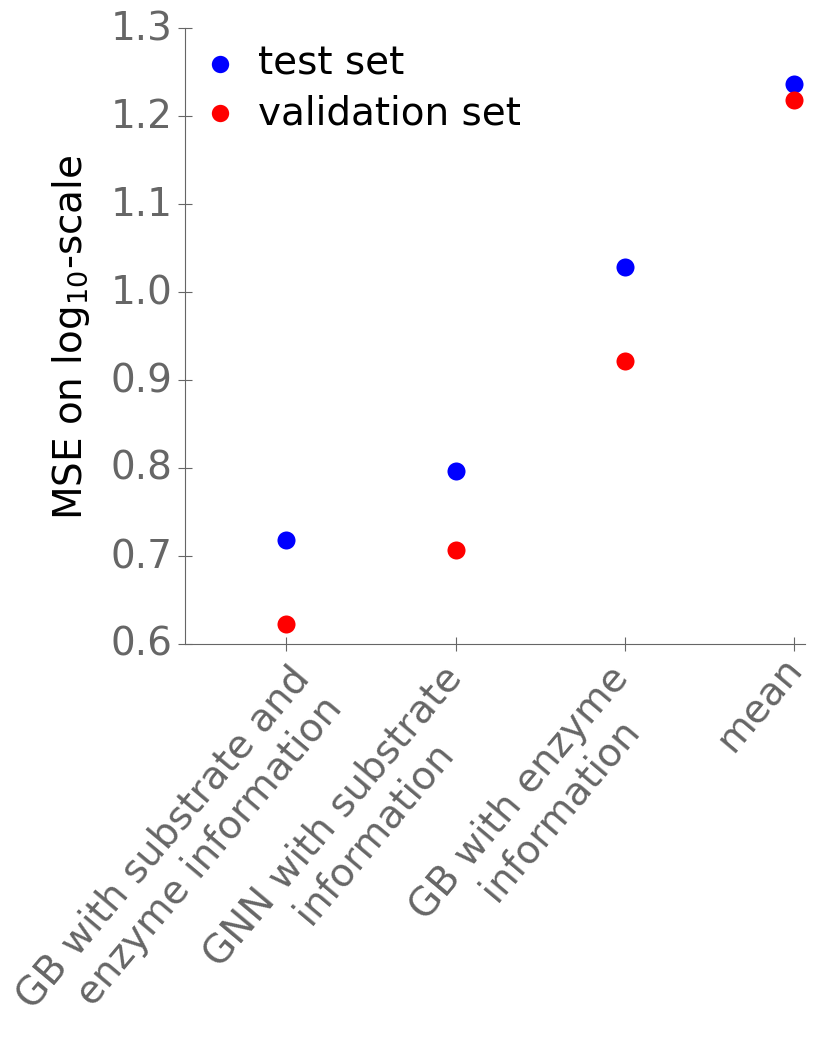

In [22]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})
labs = ["GB with substrate and \n  enzyme information",
                           "GNN with substrate \n information", "GB with enzyme \n information", "mean"]



plt.scatter(2, GNN_test_MSE , c='blue', marker='o', linewidths= 8, label = "test set")
plt.scatter(2, GNN_valid_MSE, c='red', marker='o', linewidths= 8, label = "validation set")

plt.scatter(1, GB_enzyme_sub_test_MSE, c='blue', marker='o', linewidths= 8)
plt.scatter(1, GB_enzyme_sub_valid_MSE, c='red', marker='o', linewidths= 8)

plt.scatter(3, GB_enzyme_test_MSE, c='blue', marker='o', linewidths= 8)
plt.scatter(3, GB_enzyme_valid_MSE, c='red', marker='o', linewidths= 8)

plt.scatter(4, mean_pred_test_MSE, c='blue', marker='o', linewidths= 8)
plt.scatter(4, mean_pred_valid_MSE, c='red', marker='o', linewidths= 8)



plt.ylim(0.6, 1.3)
ticks1 = [1,2,3,4]

ax.set_xticks(ticks1)
ax.set_xticklabels([])
ax.tick_params(axis='x', which="major", length=10)
ax.tick_params(axis='y', length=10)
ticks2 = [0.4, 1.4, 2.5, 3.8]

ax.set_xticks(ticks2, minor=True)
ax.set_xticklabels(labs, minor=True, y = 0.0)
ax.tick_params(axis='x', which="minor",length=0, rotation = 50)

plt.ylabel("MSE on $\log_{10}$-scale")
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.legend()
plt.show()

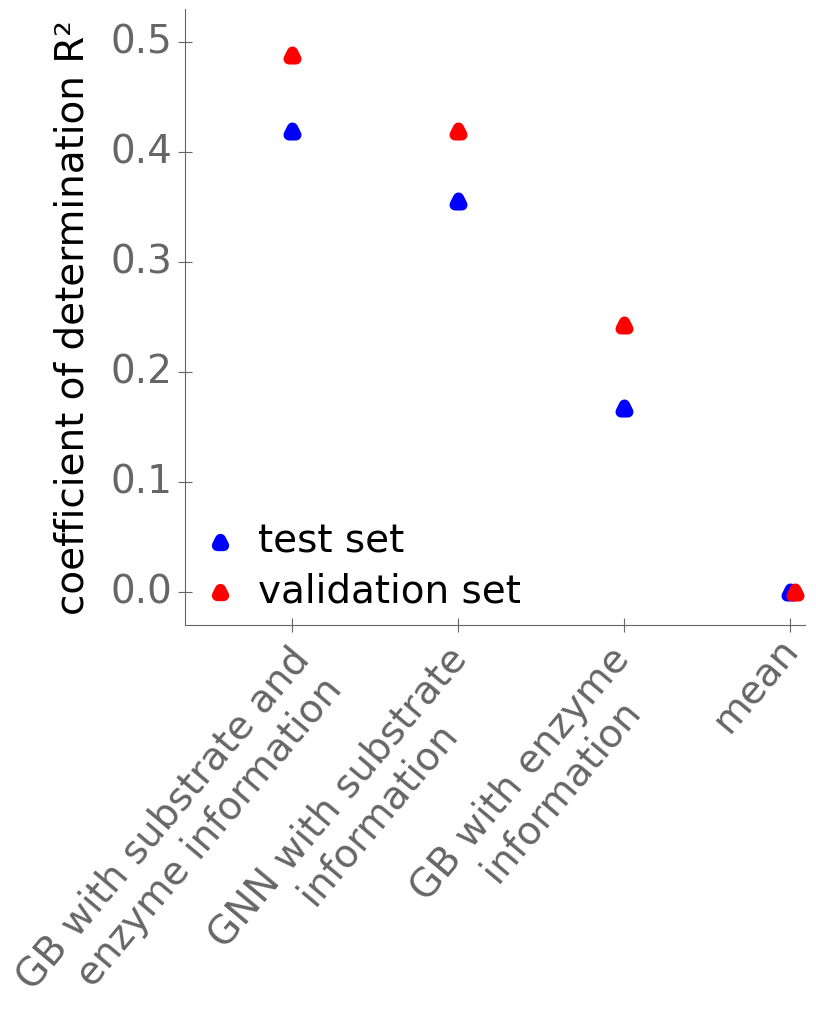

In [23]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})
labs = ["GB with substrate and \n  enzyme information",
                           "GNN with substrate \n information", "GB with enzyme \n information", "mean"]



plt.scatter(2, GNN_test_R2 , c='blue', marker='^', linewidths= 8, label = "test set")
plt.scatter(2, GNN_valid_R2, c='red', marker='^', linewidths= 8, label = "validation set")

plt.scatter(1, GB_enzyme_sub_test_R2, c='blue', marker='^', linewidths= 8)
plt.scatter(1, GB_enzyme_sub_valid_R2, c='red', marker='^', linewidths= 8)

plt.scatter(3, GB_enzyme_test_R2, c='blue', marker='^', linewidths= 8)
plt.scatter(3, GB_enzyme_valid_R2, c='red', marker='^', linewidths= 8)

plt.scatter(4, mean_pred_test_R2, c='blue', marker='^', linewidths= 8)
plt.scatter(4.03, mean_pred_valid_R2, c='red', marker='^', linewidths= 8)


plt.ylim(-0.03, 0.53)
ticks1 = [1,2,3,4]

ax.set_xticks(ticks1)
ax.set_xticklabels([])
ax.tick_params(axis='x', which="major", length=10)
ax.tick_params(axis='y', length=10)
ticks2 = [0.35, 1.4, 2.5, 3.8]

ax.set_xticks(ticks2, minor=True)
ax.set_xticklabels(labs, minor=True, y= 0.0)
ax.tick_params(axis='x', which="minor",length=0, rotation = 50)

plt.ylabel("coefficient of determination R²")
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.legend(loc = "lower left")
plt.show()